In [20]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tlviz.factor_tools import factor_match_score
import xarray as xr


In [21]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [22]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# import data

In [23]:
# read in aligned model datasets

datapath = Path('../../data/5-models/')

pro_ds = xr.open_dataset(datapath / 'pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / 'syn-aligned-models.nc')

pro_ds

<xarray.Dataset>
Dimensions:           (bootstrap: 100, replicate: 3, component: 20,
                       ortholog: 5084, clade: 3, samplename: 76)
Coordinates:
  * bootstrap         (bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * replicate         (replicate) object 'A' 'B' 'C'
  * component         (component) int64 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20
  * ortholog          (ortholog) int64 60000001 60000002 ... 60040287 60040292
  * clade             (clade) object 'HLI' 'HLII' 'LLI'
  * samplename        (samplename) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.N...
Data variables:
    componentweights  (bootstrap, replicate, component) float64 ...
    geneweights       (bootstrap, replicate, component, ortholog) float64 ...
    taxonweights      (bootstrap, replicate, component, clade) float64 ...
    sampleweights     (bootstrap, replicate, component, samplename) float64 ...
    sample            (bootstrap, replicate, samplename) object ...

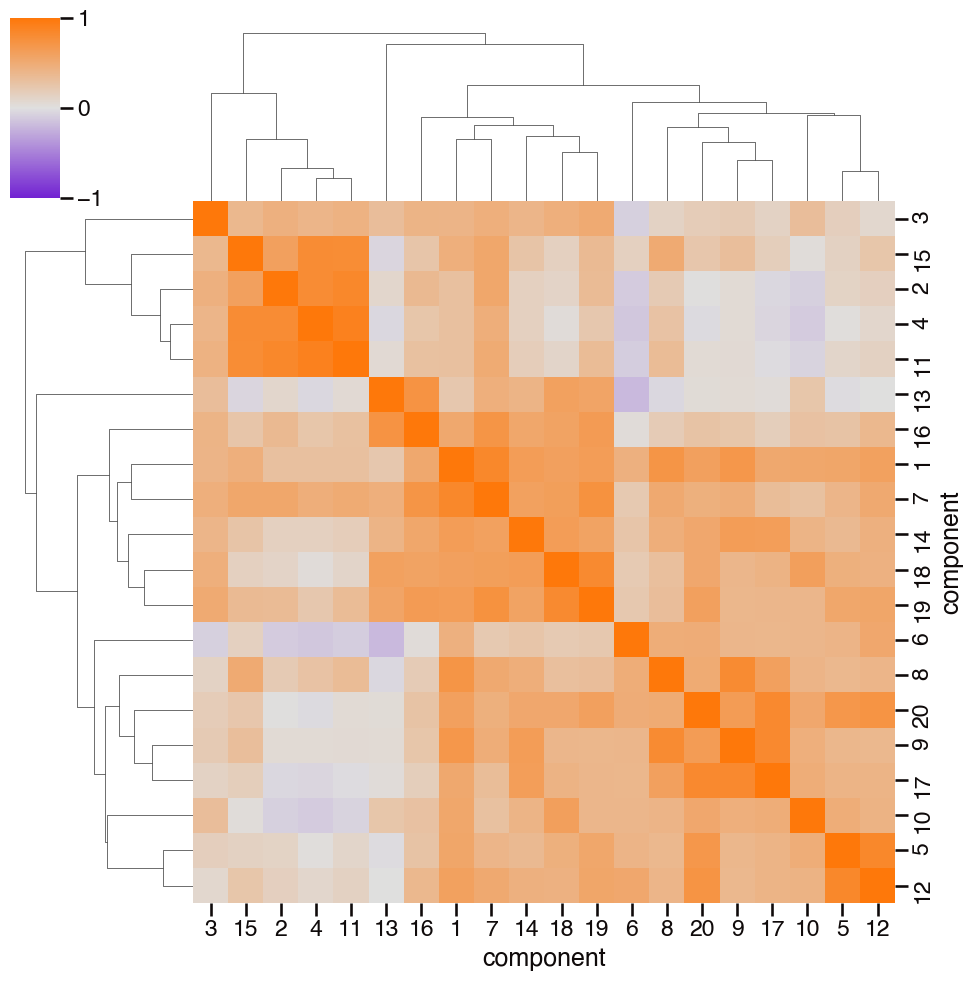

In [42]:
# assemble averaged weight profiles for each mode

cyano = 'pro'

mean_ds = pro_ds.mean(dim=['bootstrap', 'replicate'])

weights_df = pd.concat([
#     mean_ds.geneweights.T.to_pandas(), 
    mean_ds.taxonweights.T.to_pandas(), 
    mean_ds.sampleweights.T.to_pandas()]
)

# generate correlation matrix
corr_df = weights_df.corr()

# generate upper triangle mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

sns.clustermap(
    corr_df, 
#     mask=mask, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}
)


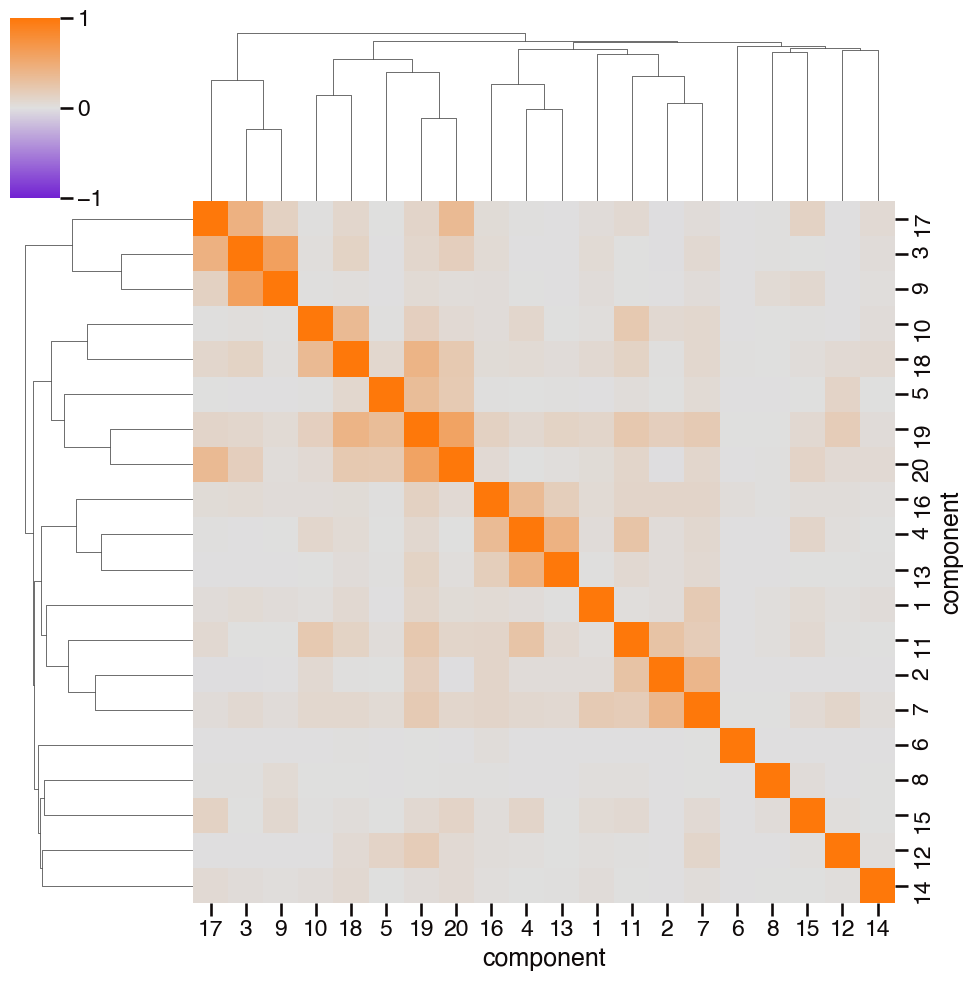

In [36]:
# pro gene weights

weights_df = pro_ds.mean(dim=['bootstrap', 'replicate']).geneweights.T.to_pandas()

# generate correlation matrix
corr_df = weights_df.corr()

# generate upper triangle mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

sns.clustermap(
    corr_df, 
#     mask=mask, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}
)


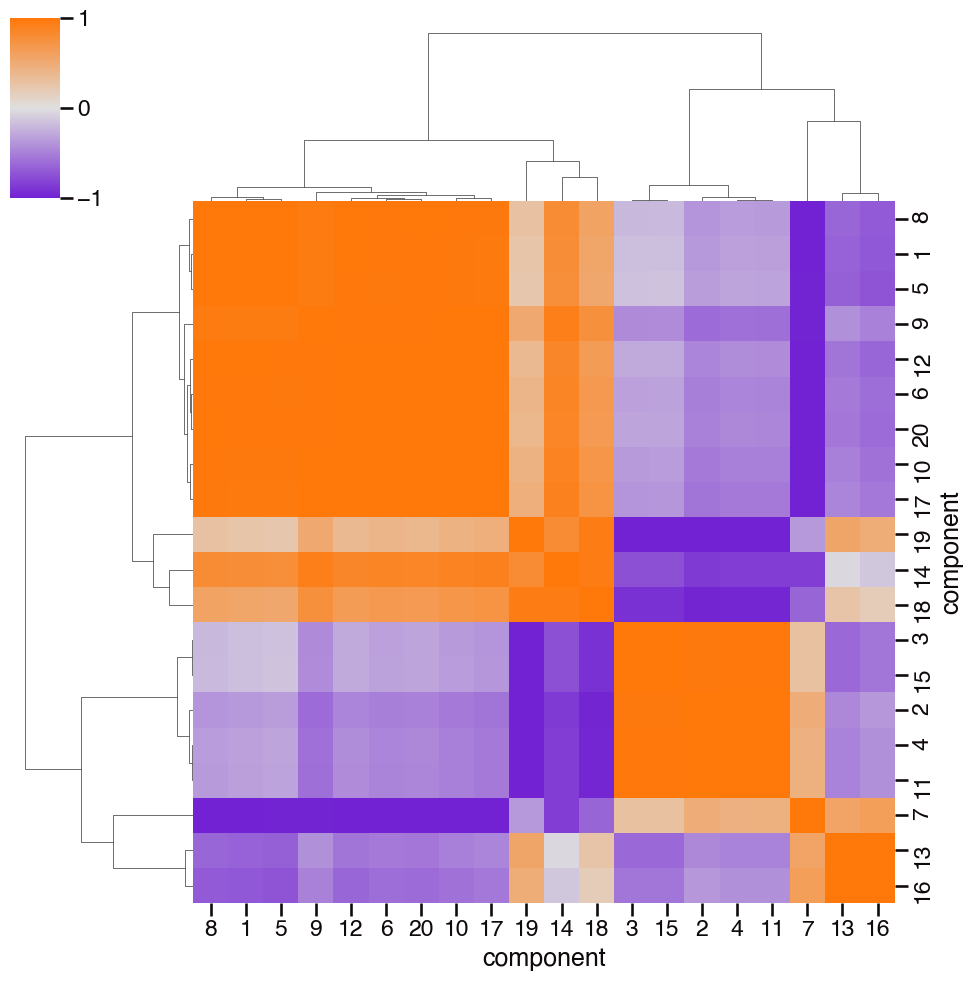

In [34]:
# pro taxon weights

weights_df = pro_ds.mean(dim=['bootstrap', 'replicate']).taxonweights.T.to_pandas()

# generate correlation matrix
corr_df = weights_df.corr()

# generate upper triangle mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

sns.clustermap(corr_df, cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5})


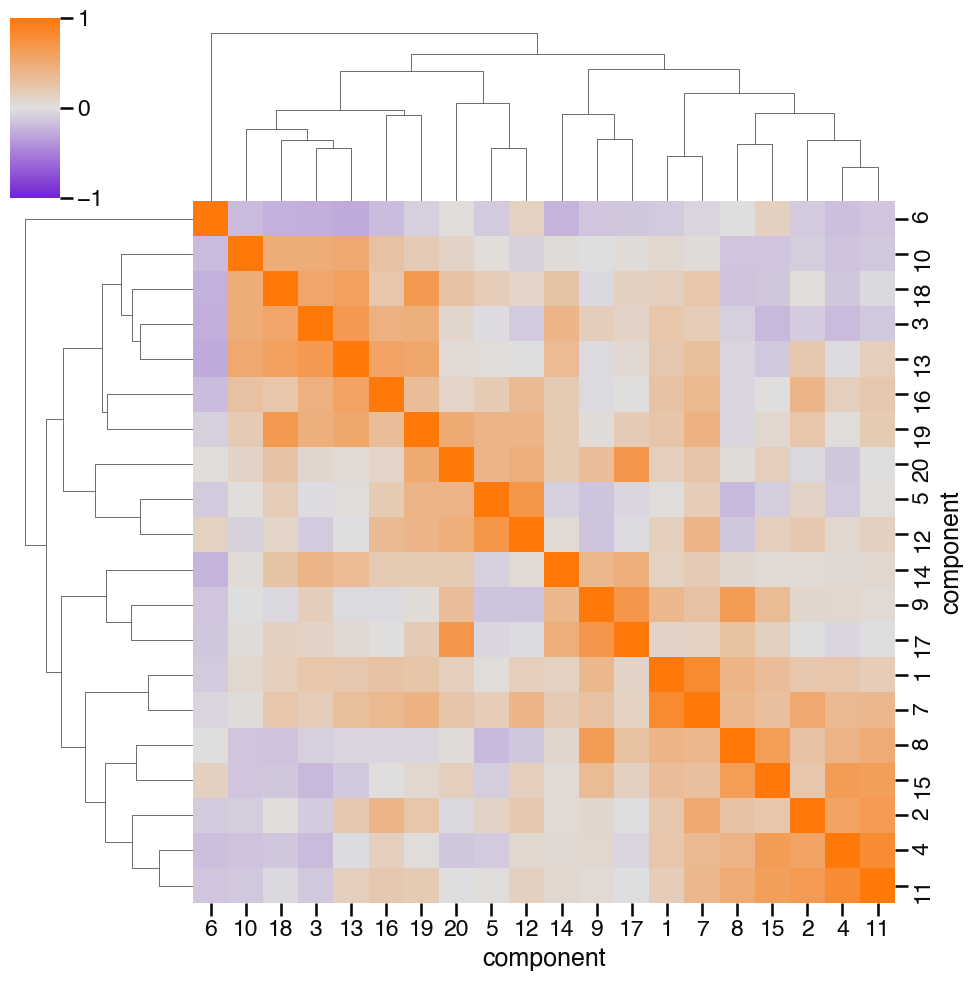

In [41]:
# pro sample weights

weights_df = pro_ds.mean(dim=['bootstrap', 'replicate']).sampleweights.T.to_pandas()

# generate correlation matrix
corr_df = weights_df.corr()

# generate upper triangle mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))

sns.clustermap(corr_df, cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5})


# Ideas:

- Look at this with FMS
- Look at DICE score?
    - Especially for genes
    

In [40]:
vec = pro_ds.mean(dim=['bootstrap', 'replicate']).sel(component=16).geneweights

vec.sortby(vec, ascending=False)[:50]

<xarray.DataArray 'geneweights' (ortholog: 50)>
array([0.37667274, 0.30554347, 0.05955608, 0.0464417 , 0.04549234,
       0.0442641 , 0.03725799, 0.0321426 , 0.03190634, 0.02924476,
       0.02807951, 0.0227936 , 0.0207086 , 0.0191952 , 0.01890806,
       0.01718785, 0.01637663, 0.01603721, 0.01486532, 0.01450013,
       0.01414596, 0.01407979, 0.01365299, 0.01164793, 0.01128509,
       0.0111784 , 0.01020105, 0.01007168, 0.01002514, 0.00989655,
       0.00961103, 0.00940674, 0.0092957 , 0.0092308 , 0.00916498,
       0.00881702, 0.0087389 , 0.00865315, 0.00841855, 0.00841663,
       0.00823243, 0.00774899, 0.00752719, 0.00700688, 0.00678328,
       0.00675562, 0.00667061, 0.00665255, 0.00652833, 0.00641653])
Coordinates:
    component  int64 16
  * ortholog   (ortholog) int64 60039089 60002365 60002595 ... 60002590 60001376